# **3. Дисбаланс выборки**

## ✍ Следующий момент, на который стоит обращать внимание во время построения модели и оценки её качества, — это **дисбаланс выборки**. В этом юните мы обсудим, что это такое и какие меры необходимо предпринимать, когда вы сталкиваетесь с задачами, в которых есть дисбаланс выборки.

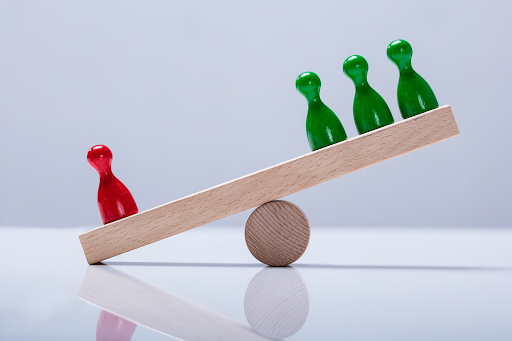

## **Несбалансированный набор данных (unbalanced dataset)** — это выборка, в которой количества примеров каждого из классов значительно отличаются.

### При этом:

+ класс большинства называется **мажоритарным (majority) классом**;
+ класс меньшинства называется **миноритарным (minority) классом**.

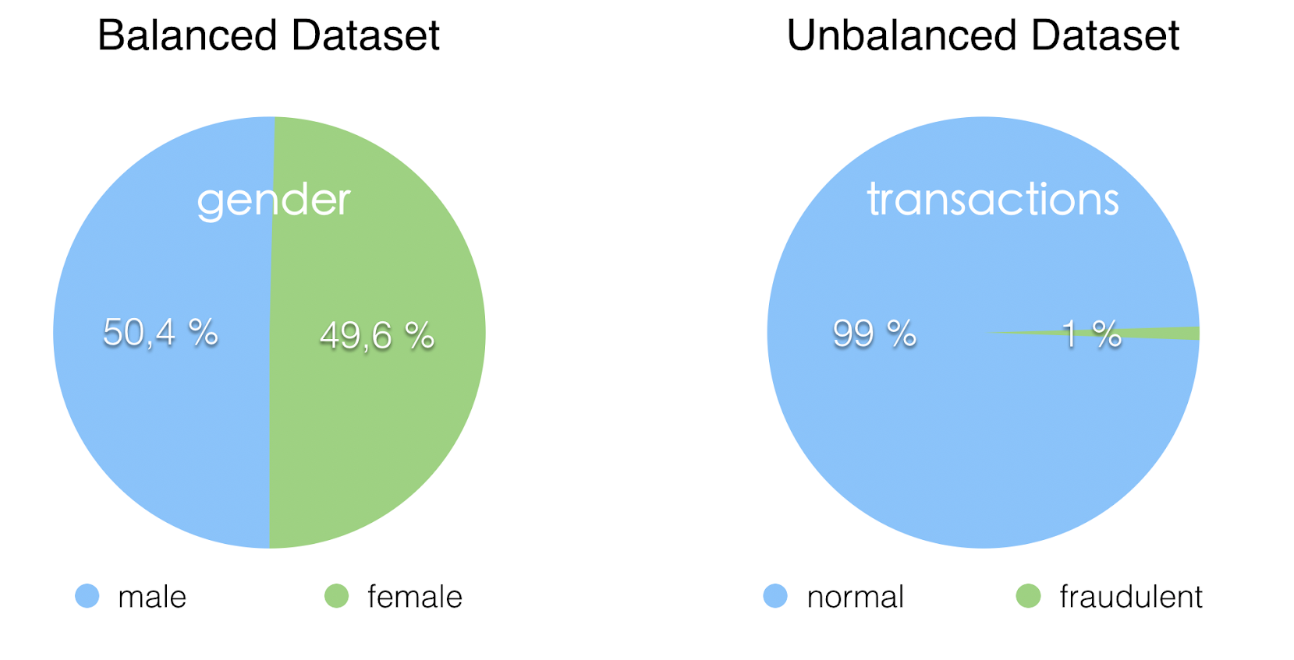

### Данное определение дисбаланса очевидно относится к задаче классификации. Понятие дисбаланса есть и в задачах регрессии, но там оно граничит с задачей поиска аномалий в данных (Anomaly Detection), которая не входит в рамки нашего курса, поэтому мы будем рассматривать только задачи классификации (для простоты — бинарной классификации).

### Типичные примеры задач, в которых исследователи чаще всего сталкиваются с дисбалансом выборки: 

+ **Обнаружение мошенничества.** Подавляющее большинство (около 90-99 %) транзакций являются немошенническими, а зафиксированных примеров мошенничества — 1-10 %.
+ **Обнаружение оттока клиентов.** Подобную задачу мы уже решали в модуле по классификации. Как правило, отток составляет около 10-30 % против 90-70 % лояльных клиентов.
+ **Распознавание лиц.** В базе данных лиц вполне стандартной является ситуация, когда в распоряжении может быть 1000 примеров фотографий первого человека против двух-трёх фотографий второго. Легко понять, что опознать второго человека по фотографии будет намного сложнее, чем первого.

### **Проблемы, которые могут возникнуть из-за несбалансированной выборки:**

+ При разбиении несбалансированной выборки на тренировочную/валидационную/тестовую увеличивается шанс попадания в одну из них объектов только одного класса, из-за чего оценка качества модели может быть необъективной.
+ Нельзя использовать метрики, не учитывающие размеры классов, такие как accuracy. Данную проблему мы обсуждали, когда знакомились с метриками классификации.
+ Стандартные методы ML, такие как дерево решений и логистическая регрессия, имеют тенденцию игнорировать класс меньшинства.

Рассмотрим влияние дисбаланса на примере датасета о качестве воды. Взглянем на соотношение классов внутри датасета:


In [71]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

water_data = pd.read_csv('water_potability.csv')

water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

In [72]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

0    0.60989
1    0.39011
Name: Potability, dtype: float64

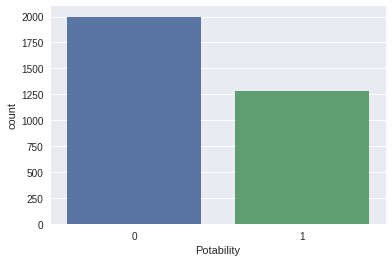

In [73]:
display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data=water_data, x='Potability');

Итак, около 61 % образцов воды являются непригодными для питья и 39 % являются пригодными. На самом деле, это небольшой дисбаланс классов (61/39). В реальных задачах мы можете столкнуться и с куда более неравномерными соотношениями, например 80/20, 90/10 или даже 99/1. Как работать с такими данными, обсудим далее.

## Задание 3.1

Что такое несбалансированная выборка?

+ Выборка, в которой значения целевой переменной распределены неравномерно.

Рассмотрим особенности разбиения выборок в условиях дисбаланса классов.

# **СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ**

### Для того чтобы снизить влияние дисбаланса классов при разбиении выборки, в наборе данных используется специальный тип разбиения, который называется **стратифицированным (stratified)**. Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.

Давайте на примере рассмотрим, как производить стратифицированное разбиение. Начнём с простого разделения hold-out, которое мы проводим с помощью функции train_test_split(). Для начала проведём обычное случайное разбиение на тренировочную и валидационную выборку (в соотношении 80/20) без стратификации:

In [74]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.620229
1    0.379771
Name: Potability, dtype: float64
Valid:
0    0.568598
1    0.431402
Name: Potability, dtype: float64


Мы видим, что соотношения классов в тренировочной выборке — 62/38, а в тестовой — 57/43. Давайте попробуем сбалансировать соотношения.

Для стратифицированного разбиения достаточно в функции train_test_split() задать параметр stratify, в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами y.

In [75]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


Теперь в каждом из наборов данных одинаковые соотношения классов — 61/39. Метрики, полученные при одинаковых соотношениях на выборках, будут более объективными.

### **А что насчёт кросс-валидации? Как организовать разбиение по методу k-fold и получить одинаковые соотношения классов?**

Для этого вместо KFold используется кросс-валидатор StratifiedKFold. Принцип работы с ним аналогичен, только, в отличие от KFold, StratifiedKFold будет разбивать выборку на части таким образом, чтобы в тренировочных и валидационных фолдах соотношения классов были приблизительно одинаковыми.

Давайте напишем код, который организует стратифицированное k-fold-разбиение на три фолда, и выведем соотношения классов в каждой из выборок:

In [76]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


Видно, что соотношения классов в тренировочной и валидационной выборках в каждом разбиении примерно одинаковы — 61/39.

Так же, как и другие кросс-валидаторы, объект класса StratifiedKFold может быть использован в функции cross_validate().

## Задание 3.2

Что такое стратифицированное разбиение?

+ Разбиение, при котором сохраняется соотношение страт (классов) в каждой из групп (выборок).

## Задание 3.3

Ниже представлен код для генерации задачи классификации и отрисовки диаграммы рассеяния с цветовой группировкой по классам:

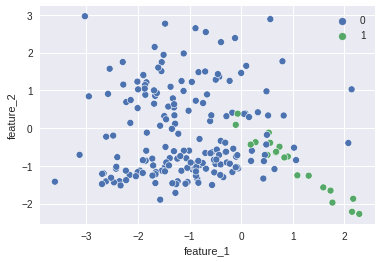

In [80]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y);

Разбейте исходный набор данных на тренировочный и валидационный со стратификацией по классам в соотношении 80/20. В качестве значения параметра random_state возьмите число 42.

Постройте диаграммы рассеяния с цветовой группировкой по классам для валидационной выборки.

Из приведённых ниже диаграмм выберите ту, которая соответствует полученному разбиению:

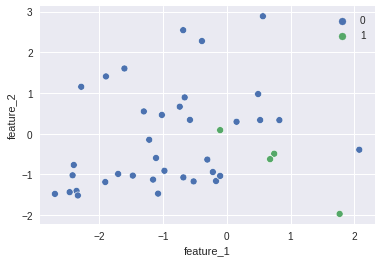

In [81]:
X_train, X_valid, y_train, y_valid= model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y);

# **ВЫБОР МЕТРИК В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ**

Мы поговорили о том, как производить разбиение в условиях дисбаланса классов. Следующий пункт в нашем списке проблем — это использование метрик, которые плохо работают с дисбалансом.

Основной представитель таких метрик — это знакомая нам **accuracy**, доля угаданных моделью ответов. Вспомним её формулу:

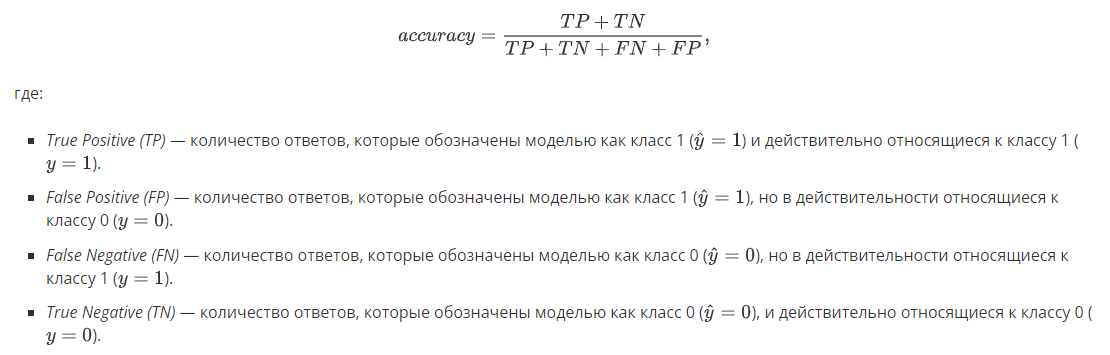

### **Загвоздка заключается в том, что данная метрика абсолютно не отражает предсказательную способность модели в отношении каждого из классов. В условиях дисбаланса классов данная метрика может дать ложные представления о качестве модели.**

Поэтому используются метрики, которые концентрируются на каждом из классов отдельно, — это знакомые нам из модуля по классификации precision, recall и $F_1$-score.

Давайте на примере посмотрим, насколько важен выбор метрики в случае дисбаланса выборки.

Разобьём выборку на тренировочную и валидационную в соотношении 80/20, используя стратифицированное разбиение, затем обучим модель дерева решений, сделаем предсказание для каждой из выборок и сформируем отчёт о метриках на валидационной выборке с помощью функции classification_report().

In [32]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        36
           1       0.50      0.50      0.50         4

    accuracy                           0.90        40
   macro avg       0.72      0.72      0.72        40
weighted avg       0.90      0.90      0.90        40



Из отчёта о метриках классификации видно, что для валидационной выборки метрика accuracy составляет 0.77, что, в принципе, является довольно хорошим результатом. Однако если мы посмотрим на метрики recall и f1-score для каждого из классов в отдельности, мы увидим, что метрики для класса 0 значительно выше, чем метрики для класса 1.

+ Precision для класса 1 составляет 0.81, то есть из всех образцов воды, причисленных моделью к классу пригодных для питья, 81 % действительно являются таковыми.
+ Recall для класса 1 составляет 0.55, то есть из всех образцов в действительности пригодной для питья воды модель посчитала пригодными лишь 55 %, а остальные 45 % посчитала непригодными.
+ $F_1$-мера — среднее гармоническое между precision и recall — составила 0.65 для класса 1 и 0.83 — для класса 0. Разница довольно далека от нуля, а значит построенная нами модель больше контролируется на образцах воды, непригодных для питья, и обладает плохой различающей способностью.

Однако мы не смогли бы выявить этот факт, если бы ориентировались только на метрику accuracy. Одной из причин такого результата является дисбаланс классов: образцов непригодной для питья попросту больше, чем пригодных для питья.

### **Примечание.** Поскольку простая accuracy вызывает сомнения в задачах с сильным дисбалансом, были разработаны специальные метрики, основанные на accuracy: это функционал Каппа Коэна (Cohen’s Kappa) и balanced accuracy. Подробнее о них вы можете прочитать здесь.

## Задание 3.4

На какие целевые метрики вы будете ориентироваться при обучении RandomForestClassifier на несбалансированной выборке?

+ $F_1$-score
+ Precision
+ Recall

## Задание 3.5

Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.

Обучите модель логистической регрессии на тренировочной выборке (все параметры оставьте по умолчанию).

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.


In [33]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import datasets 
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X_train, X_valid, y_train, y_valid= model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
log_reg = linear_model.LogisticRegression()
log_reg.fit(X_train, y_train)
y_valid_pred = log_reg.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.50      0.25      0.33         4

    accuracy                           0.90        40
   macro avg       0.71      0.61      0.64        40
weighted avg       0.88      0.90      0.88        40



## Задание 3.6 (на самопроверку)
Воспользуйтесь функцией plot_probabilities_2d(), которую мы написали в модуле по классификации, для того чтобы построить разделяющую поверхность логистической регрессии.

In [82]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученную в задании 3.5 логистическую регрессию.

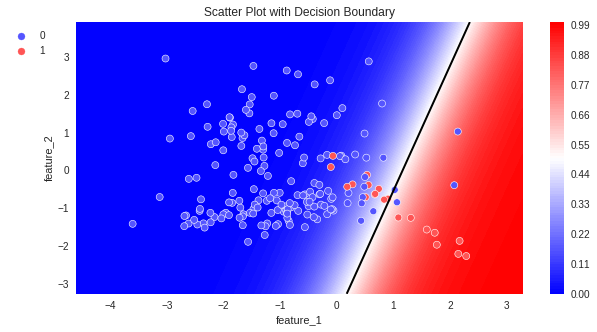

In [45]:
plot_probabilities_2d(X, y, log_reg)

# **ПОСТРОЕНИЕ МОДЕЛИ В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ**

Итак, мы посмотрели, как дисбаланс выборки может оказывать влияние на способность модели находить класс меньшинства. Но как с этим бороться?

Существует **несколько способов уменьшить влияние дисбаланса на обучение модели:**

+ **Взвешивание объектов.** В функцию ошибки добавляется штраф, прямо пропорциональный количеству объектов каждого класса. Это очень похоже на регуляризацию, которую мы изучали ранее.
+ **Выбор порога вероятности.** Этот подход мы с вами тоже уже использовали ранее. Он заключается в том, что мы подбираем такой порог вероятности (по умолчанию он равен 0.5 во всех моделях), при котором на валидационной выборке максимизируется целевая метрика (например, -score).
+ **Сэмплирование** (sampling) — перебалансировка выборки искусственным путём:
 + **oversampling** — искусственное увеличение количества объектов миноритарного класса;
 + **undersampling** — сокращение количества объектов мажоритарного класса.

 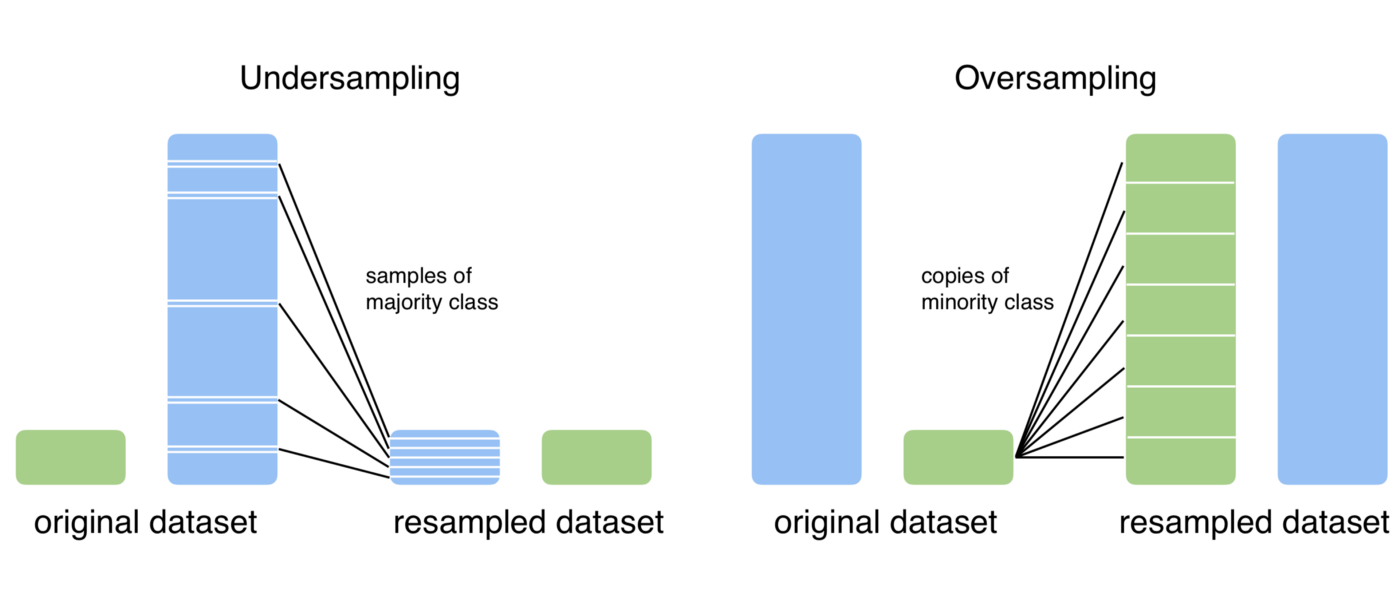

Здесь могут использоваться алгоритмы генерации искусственных данных, такие как NearMiss, SMOTE (Synthetic Minority Oversampling Techniques) и ADASYN (Adaptive Synthetic).

Мы рассмотрим наиболее популярный алгоритм — **SMOTE**, об остальных можно прочитать здесь. 

*Давайте последовательно рассмотрим каждый из методов.*

## **ВЗВЕШИВАНИЕ ОБЪЕКТОВ**

Большинство моделей, реализованных в sklearn, имеют параметр class_weight — веса классов. Чтобы сбалансировать важность классов, обычно берут веса объектов класса-большинства (мажоритарного класса) равным

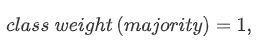

а веса объектов малочисленного (миноритарного) класса вычисляются по следующей формуле:

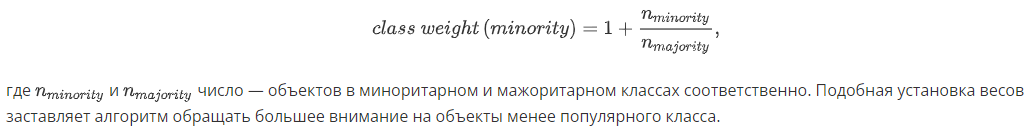

Для того чтобы задать веса классам по приведённым выше формулам, достаточно в инициализаторе модели выставить параметр class_weight='balanced'.

Посмотрим на реализацию на примере дерева решений:



In [9]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.63      0.76      0.69       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



Так гораздо лучше! Обратите внимание на метрики класса 1: значение $F_1$ поднялось с 0.65 до 0.69. Это произошло потому, что мы стали чаще находить образцы пригодной для питья воды, за счёт чего recall увеличился с 0.55 до 0.76 (правда, немного упал precision).

Да, метрики для класса 0 стали ниже, и у нас слегка упала метрика accuracy, но таков закон баланса — «чтобы где-то прибыло, надо, чтобы где-то убыло». Пусть в целом картина всё ещё не идеальна, но она заметно улучшилась. Разница метрик между классами значительно сократилась. 

## Задание 3.7

Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.

Обучите модель логистической регрессии на тренировочной выборке, установив сбалансированные веса для классов.

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.

In [ ]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
log_reg_balanced = linear_model.LogisticRegression(class_weight='balanced')
log_reg_balanced.fit(X_train, y_train)
y_valid_pred = log_reg_balanced.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90        36
           1       0.33      0.75      0.46         4

    accuracy                           0.82        40
   macro avg       0.65      0.79      0.68        40
weighted avg       0.90      0.82      0.85        40



## Задание 3.8 (на самопроверку)
Воспользуйтесь функцией plot_probabilities_2d(), которую мы написали в модуле по классификации, для того чтобы построить разделяющую поверхность логистической регрессии со сбалансированными весами классов.

Примечание. Код функции plot_probabilities_2d() вы можете найти в задании 3.6.

Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученную в задании 3.7 логистическую регрессию.

Сравните разделяющую поверхность, построенную в задании 3.5, с полученной вами поверхностью в данном задании.

In [ ]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


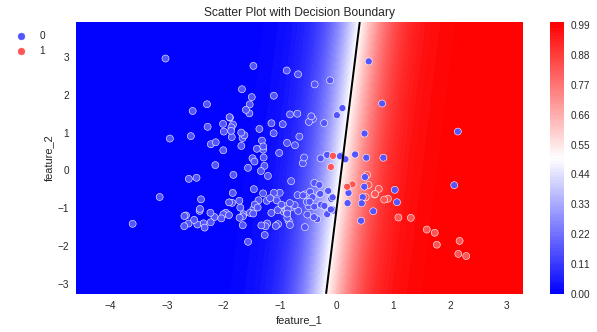

In [ ]:
plot_probabilities_2d(X, y, log_reg_balanced)

# **ВЫБОР ПОРОГА ВЕРОЯТНОСТИ. PR-КРИВАЯ**

### Следующий метод, о котором мы поговорим, — это выбор **порога вероятности (бинаризации)**.

Мы знаем, что любой классификатор предсказывает для объектов вероятности их принадлежности к классу 1 (^P) и классу 0 (Q = 1 - ^P). Класс объекта по умолчанию определяется по следующему правилу:

+ Если вероятность ^P > 0.5, то объект относится моделью к классу 1.
+ Если вероятность ^P <= 0.5, то объект относится моделью к классу 0.

Однако из модуля по классификации мы также знаем, что данный порог можно поменять и сделать его равным, например, 0.15 или 0.7. Это является очень распространённой практикой, ведь для каждой задачи может быть свой оптимальный порог вероятности.

Ранее мы уже подбирали оптимальный порог вероятности, строя графики зависимости метрик от порога вручную. Вспомнить, как это было, вы можете в модуле по классификации. В данном модуле мы посмотрим на эту задачу иначе. А поможет нам **PR-кривая**.

## **PR-кривая (precision-recall curve)** — это график зависимости precision от recall при различных значениях порога вероятности.

Для построения данного графика мы берём множество различных порогов вероятности (0.1, 0.15, 0.2, …1) и вычисляем метрики precision и recall при разных порогах вероятности. Если мы построим линейный график зависимости precision от recall, то получим примерно следующую картину:

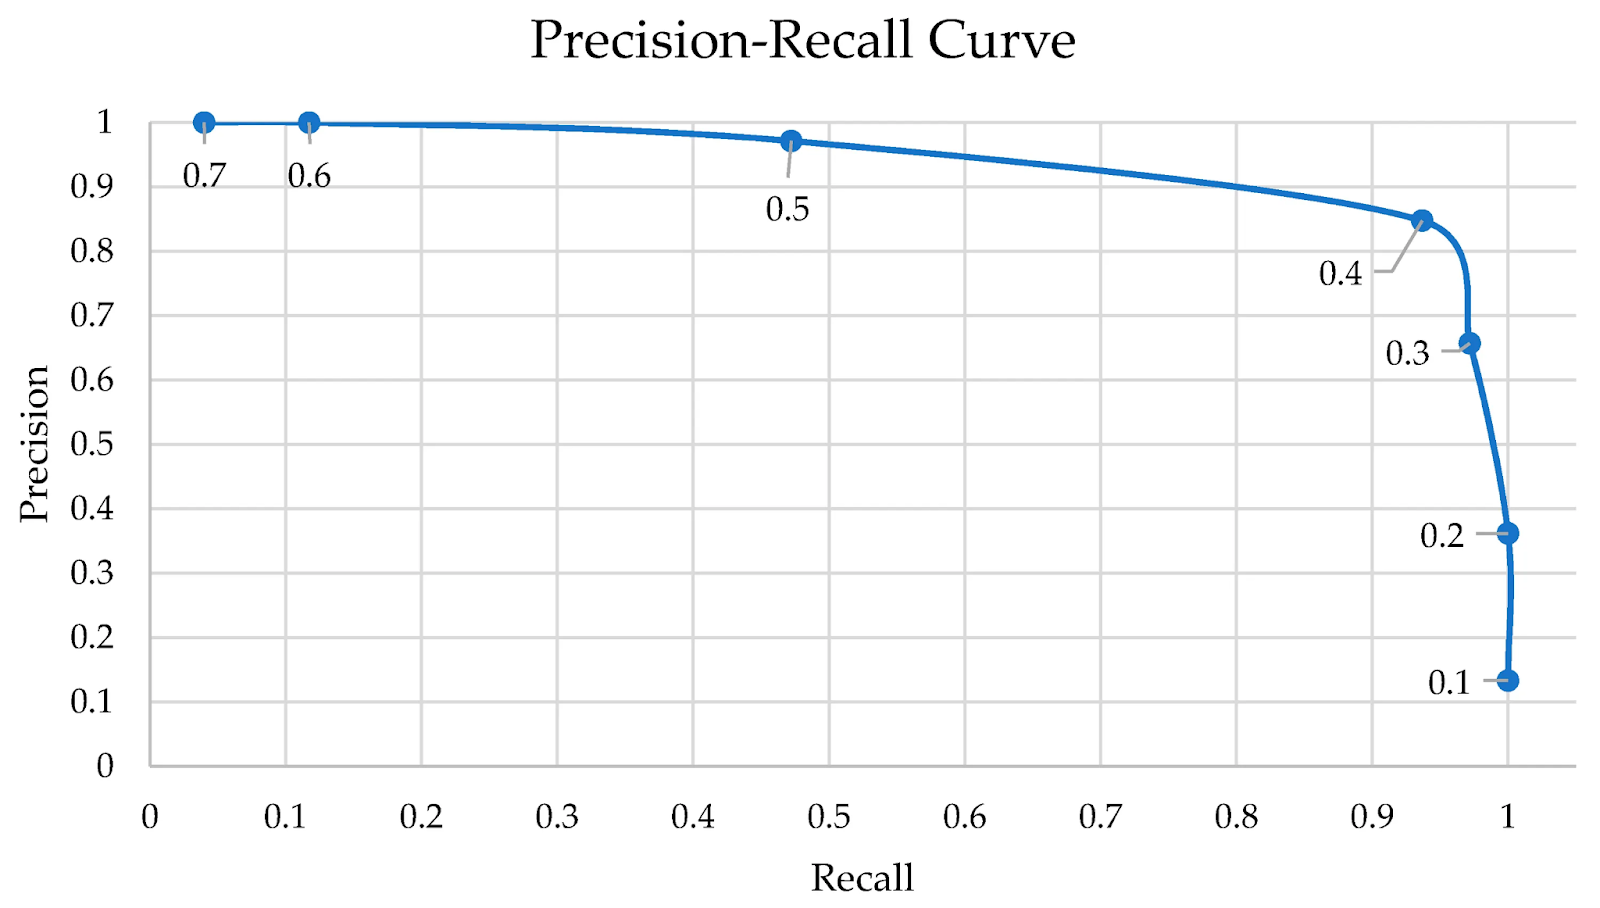

Подписи к точкам на графике — пороги вероятности.

## **Что нам даёт такая кривая?**

1. Во-первых, PR-кривая — это графическая метрика качества модели, она комплексно отражает и precision, и recall одновременно (как $F_1$-мера) и особенно хороша в условиях дисбаланса классов.

Качество определяется площадью (PR AUC) под кривой: чем ближе значение площади к 1, тем лучше модель. Идеальная модель — та, у которой площадь равна 1. У такой модели и precision, и recall равны 1. Конечно же, таких моделей не существует в природе.

Если площадь под PR-кривой меньше 0.5, модель считается очень слабой (качество её распознавания хуже, чем подбрасывание монетки).

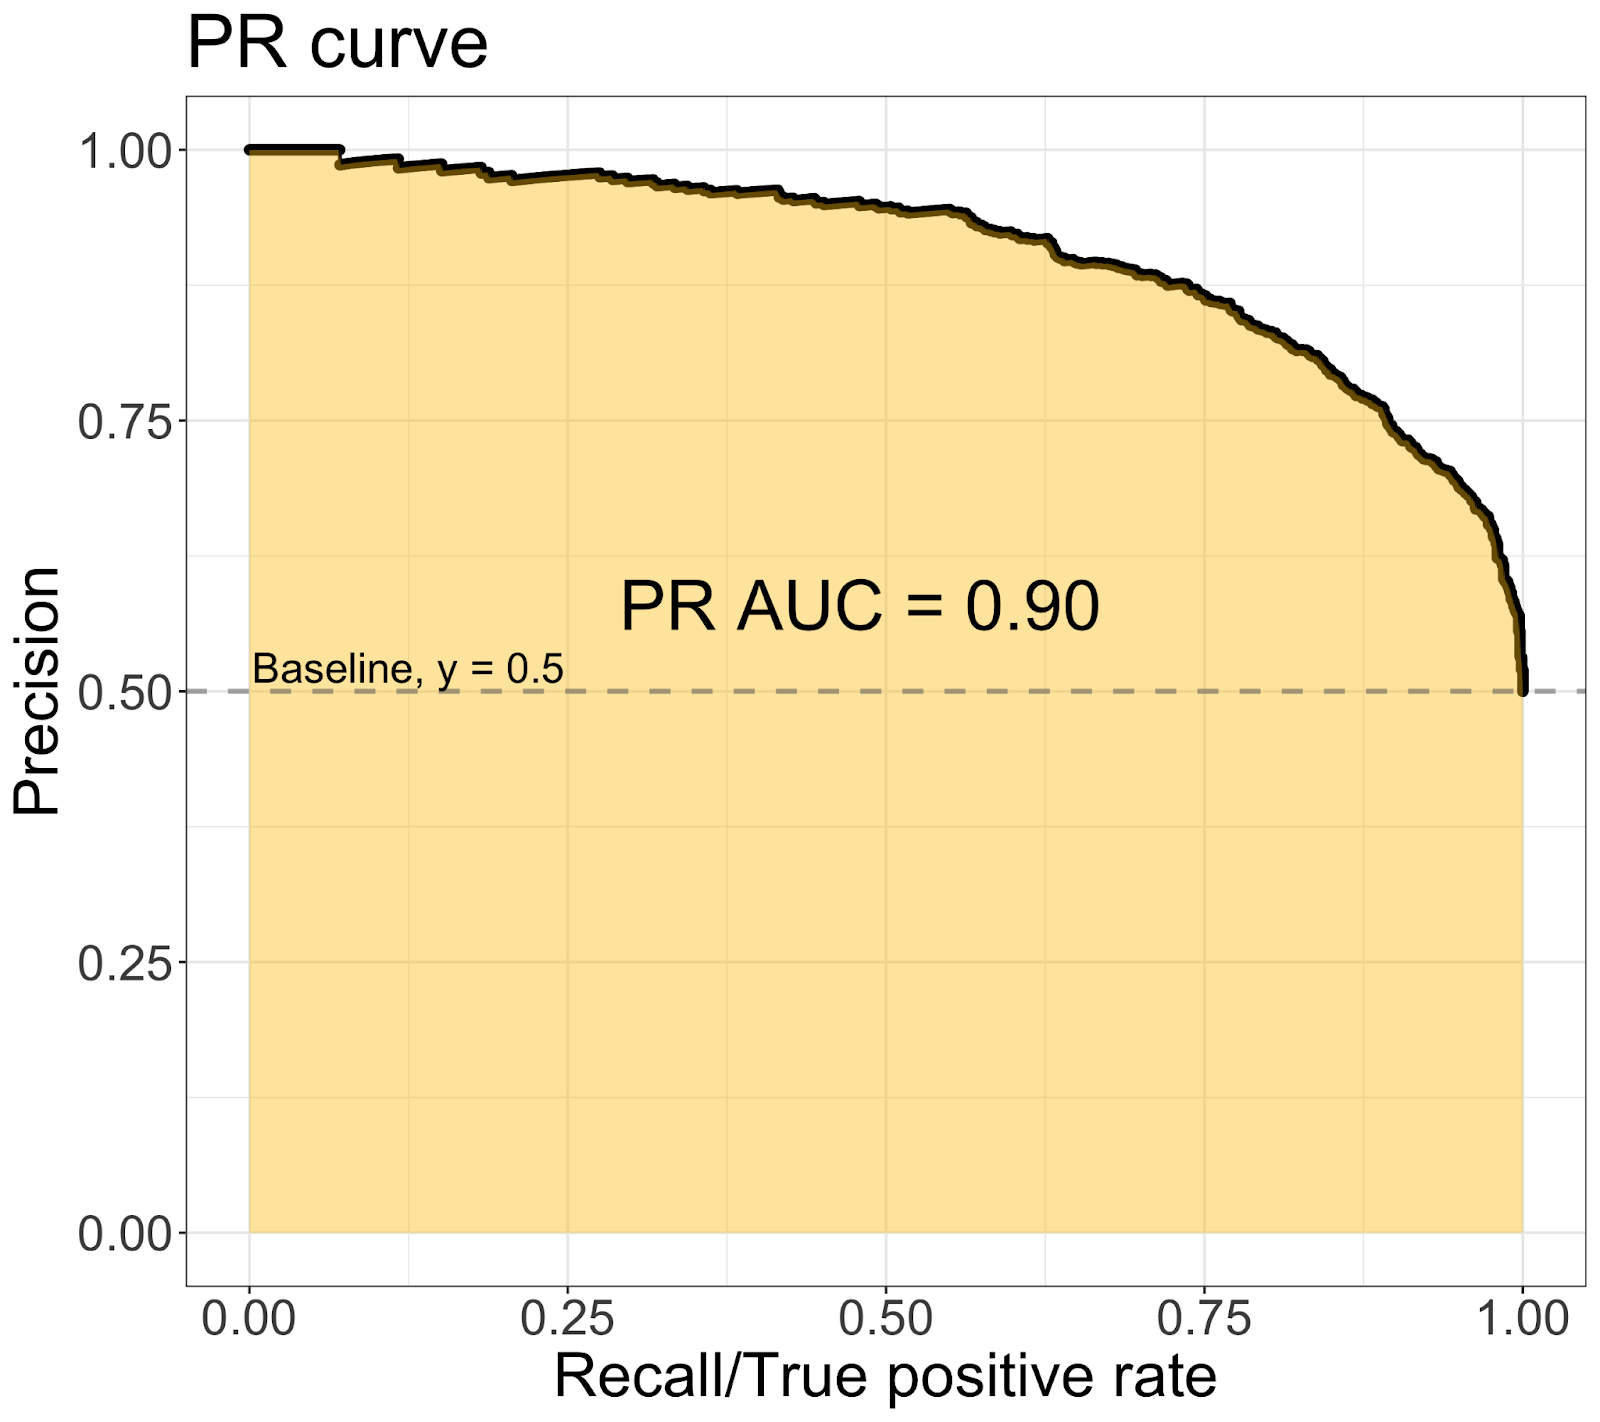

По площади под PR-кривой мы можем сравнивать модели между собой.

Например, ниже изображены PR-кривые для логистической регрессии (Logistic Regression) и случайного леса (Random Forest). Площадь под первой кривой — 0.680, под второй — 0.688. Можно сделать вывод, что с небольшим отрывом на тысячных долях побеждает случайный лес.

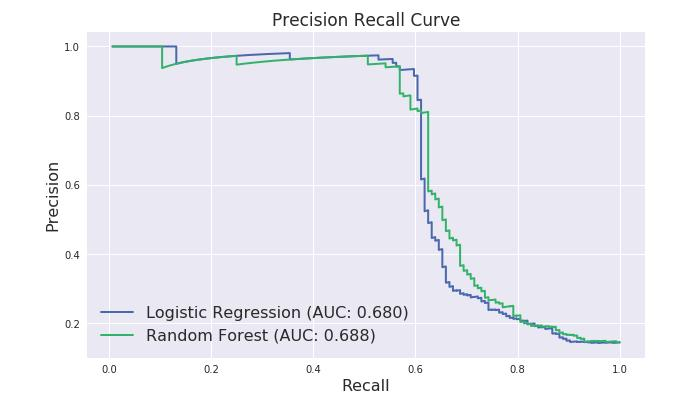

2. Во-вторых, с помощью PR-кривой удобно находить оптимальный порог вероятности. Главное — определиться с критерием этой оптимальности. На кривой мы можем найти такие точки, в которых наблюдается наилучшее значение precision или recall или среднее геометрическое между ними ($F_1$-score). 

О том, как выбирать метрику в зависимости от задачи, мы говорили в модуле по классификации.

Подберём порог вероятности с помощью PR-кривой для нашего примера. Так как порог вероятности является внешним параметром модели, будет правильнее подбирать его на кросс-валидации, организованной на тренировочном наборе данных, а итоговое качество оценивать на отложенной выборке.

Пусть мы хотим найти такой порог вероятности, при котором наблюдается максимум метрики $F_1$ = 2 * precision * recall / (recall + precision) для класса 1 (питьевая вода).

Перед построением PR-кривой нам необходимо предсказать вероятность принадлежности к классу 1 на валидационных фолдах кросс-валидации.

Для предсказания вероятностей используем функцию cross_val_predict(). Данная функция выполняет кросс-валидацию и возвращает предсказания для валидационных фолдов. Если ей передать параметр method='predict_proba', она вернёт предсказанные вероятности для каждого из классов на всех фолдах. Остальные параметры аналогичны параметрам функции cross_validate().

In [10]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')

In [11]:
y_cv_proba_pred

array([[0.        , 1.        ],
       [0.24561404, 0.75438596],
       [1.        , 0.        ],
       ...,
       [0.60621762, 0.39378238],
       [1.        , 0.        ],
       [0.03030303, 0.96969697]])

Это массив из вероятностей для каждого образца воды. Первое число в строке — вероятность того, что данный образец является непригодным для питья, а второе — вероятность того, что данный образец пригоден для питья.

Нас интересует класс 1 (пригодная для питья вода). Это второй столбец в матрице вероятностей (индекс 1). Выделим этот столбец из матрицы с вероятностями:

In [12]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

Теперь мы можем построить PR-кривую. Для этого воспользуемся функций precision_recall_curve() из модуля metrics библиотеки sklearn. В данную функцию нужно передать истинные метки классов и предсказанные вероятности. Взамен она вернёт три массива: значения метрик precision и recall, вычисленных на различных порогах вероятности, и сами пороги вероятности:

In [13]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.02739726 0.02898551 0.05       0.07407407]
Precision scores: [0.39007634 0.50050659 0.50357873 0.50437919 0.5043837 ]
Recall scores: [1.         0.9667319  0.96379648 0.95792564 0.95694716]


Осталось дело за малым. Вычислим значение $F_1$-score при различных порогах вероятности и найдём такой порог вероятности, при котором она максимальна. Сделать это можно с помощью функции argmax() из модуля numpy — она возвращает индекс максимального элемента массива.

Далее построим PR-кривую и отметим на ней точку максимума $F_1$-score.

Best threshold = 0.33, F1-Score = 0.69


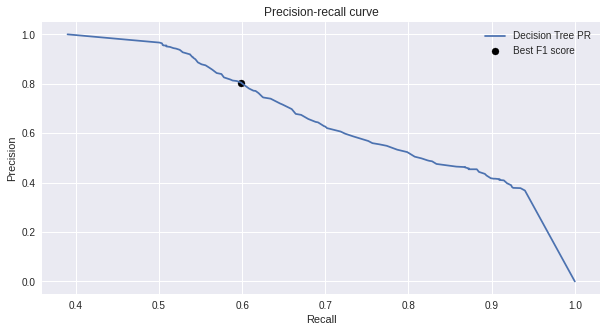

In [14]:
#Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')
#Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

Итак, согласно нашим вычислениям и построенной PR-кривой, максимум $F_1$ (0.69) на кросс-валидации наблюдается при пороге вероятности 0.33.

Сделаем предсказание классов с таким порогом для всех объектов из отложенной валидационной выборки и выведем отчёт о метриках:

In [19]:
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
threshold_opt = 1
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       400
           1       0.00      0.00      0.00       256

    accuracy                           0.61       656
   macro avg       0.30      0.50      0.38       656
weighted avg       0.37      0.61      0.46       656



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Итак, при применении метода подбора вероятности увеличилось значение метрик recall и $F_1$ для класса 1. Нам удалось сократить разницу метрик между классами и заставить модель практически одинаково хорошо предсказывать классы питьевой и непитьевой воды.

**Примечание.** Чтобы вычислить площадь под PR-кривой, используется функция auc() из модуля metrics библиотеки sklearn. В данную функцию нужно передать значения метрик recall и precision при различных порогах вероятности:

In [20]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))


PR AUC: 0.79


## Задание 3.9

Что такое PR-кривая?

+ График зависимости precision от recall при различных порогах вероятности.

## Задание 3.10

Ниже представлены PR-кривые для трёх различных моделей:

+ Красная — модель № 1;
+ Синяя — модель № 2;
+ Зелёная — модель № 3.

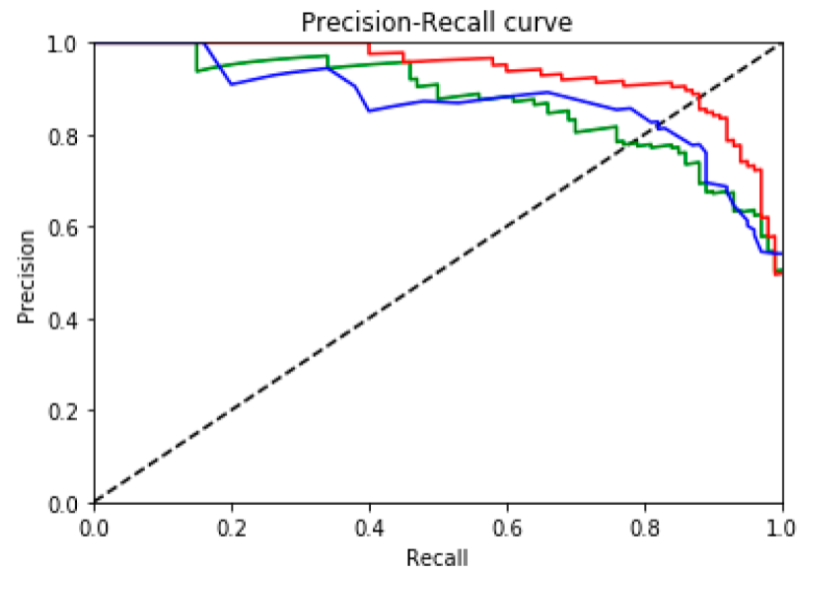

Какую из моделей вы бы выбрали, если бы оценка качества производилась по метрике PR AUC?

+ Модель № 1

# **СЭМПЛИРОВАНИЕ**

Следующий подход работы в условиях дисбаланса классов, который мы рассмотрим, — **сэмплирование**, а точнее — **пересэмплирование (oversampling)**.

### Идея очень проста: если у нас мало наблюдений миноритарного класса, следует искусственно увеличить их количество.

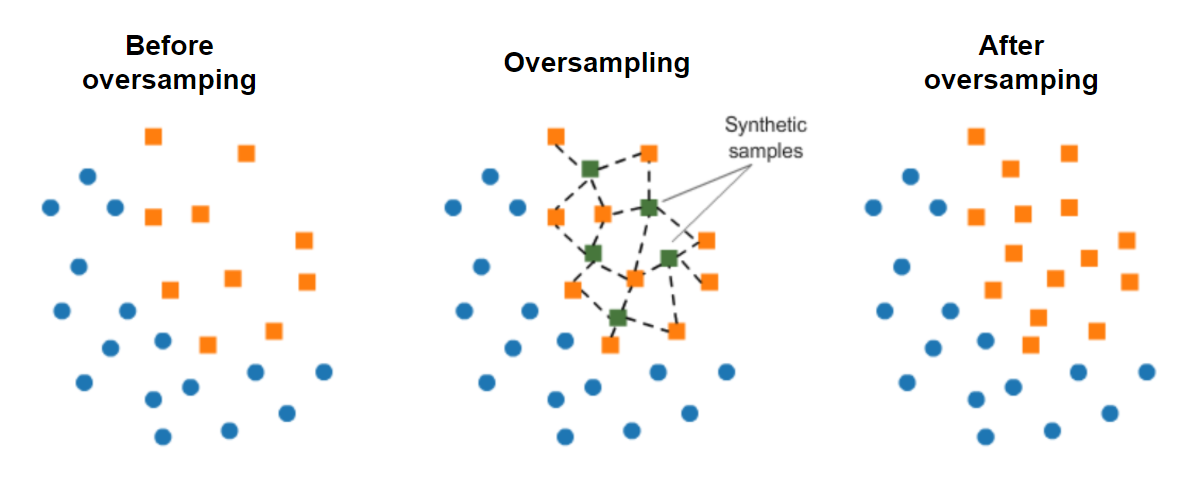

### Простейшая стратегия пересэмплирования — продублировать объекты малого класса. Но это неинтересно и работает довольно плохо. Поэтому были созданы специальные алгоритмы генерации искусственных данных. Самый популярный из таких алгоритмов — алгоритм **SMOTE (Synthetic Minority Oversampling Techniques)**.

## В основе алгоритма лежит идея генерации некоторого количества искусственных наблюдений, которые были бы «похожи» на наблюдения, имеющиеся в миноритарном классе, но при этом не дублировали их.

Мы не будем сейчас заострять внимание на математической работе алгоритма, и вместо этого посмотрим на 2D-анимацию работы данного метода:

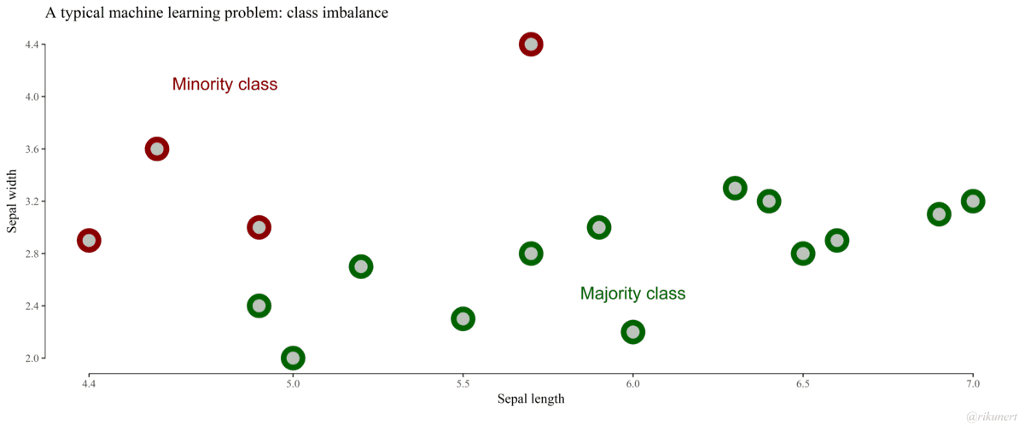

*Тем, кто заинтересуется математической составляющей методов сэмплирования, советуем заглянуть в эту статью — в ней описаны различные стратегии сэмплирования, включая алгоритм SMOTE.*

### Алгоритмов сэмплирования, в том числе SMOTE, нет в стандартном пакете sklearn — они содержатся в библиотеке imblearn (imbalanced-learn). Команды для установки приведены далее.

In [21]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Все алгоритмы пересэмплирования находятся в модуле over_sampling библиотеки imblearn. Импортируем оттуда алгоритм SMOTE:

In [83]:
from imblearn.over_sampling import SMOTE

Создадим объект класса SMOTE и вызовем у него метод fit_sample(), передав в него обучающую выборку (X_train, y_train). Затем выведем количество наблюдений каждого из классов до и после сэмплирования:

In [84]:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (160, 2)
Class balance before oversampling: 
0    144
1     16
dtype: int64
----------------------------------------
Train shape after oversampling: (288, 2)
Class balance after oversampling: 
0    144
1    144
dtype: int64


Итак, размер выборки увеличился с 2620 примеров до 3196, и теперь количество наблюдений каждого из классов одинаково (1598/1598).

Попробуем обучить нашу модель на сгенерированных обучающих данных и сделать предсказание на валидационной выборке (обратите внимание, что с валидационным набором данных мы не производим никаких преобразований), чтобы рассчитать метрики:

In [24]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       400
           1       0.63      0.78      0.69       256

    accuracy                           0.73       656
   macro avg       0.73      0.74      0.73       656
weighted avg       0.75      0.73      0.73       656



Нам удалось поднять метрики для класса 1 на валидационной выборке и снова найти баланс между метриками классов. Однако мы потеряли в метриках для класса 0.

## Задание 3.11

Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.

Сбалансируйте тренировочную выборку с помощью алгоритма SMOTE. В качестве значения параметра random_state возьмите число 42, остальные параметры оставьте по умолчанию.

Обучите модель логистической регрессии на пересэмплированной тренировочной выборке. Все параметры оставьте по умолчанию.

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.

In [85]:
from sklearn import datasets
from imblearn.over_sampling import SMOTE
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)

sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)
log_reg_smote = linear_model.LogisticRegression(class_weight='balanced')
log_reg_smote.fit(X_train_s, y_train_s)
y_valid_pred = log_reg_smote.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



## Задание 3.12 (на самопроверку)

Воспользуйтесь функцией plot_probabilities_2d(), которую мы написали в модуле по классификации, для того чтобы построить разделяющую поверхность логистической регрессии со сбалансированными весами классов.

Примечание. Код функции plot_probabilities_2d() вы можете найти в задании 3.6.

Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученную в задании 3.11 логистическую регрессию.

Сравните разделяющую поверхность, построенную в заданиях 3.5 и 3.7, с полученной вами поверхностью в данном задании.

In [ ]:
plot_probabilities_2d(X, y, log_reg_balanced)

→ Заметьте, что качество всех рассмотренных методов приблизительно одинаковое — они дают примерно идентичное значение метрик. Так получилось для конкретного примера набора данных. Для другого набора данных может получиться совершенно иной результат. Какой из методов сработает лучше, заранее сказать нельзя.

## **✍ В этом юните мы:**

+ познакомились с дисбалансом выборки и узнали, как он может оказывать влияние на обучение модели;
+ изучили, как правильно организовать разбиение выборки, чтобы получать наиболее объективные оценки качества;
+ поговорили о выборе метрик в условиях несбалансированной выборки;
+ обсудили методы настройки модели.

На самом деле плохая различающая способность может быть связана не только с дисбалансом выборки. На качество моделирования влияют и другие факторы:

+ Сложность модели. Выбранная нами модель дерева решений является довольно простым классификатором. Имеет смысл задуматься над применением более сложных методов, например случайного леса.
+ Недостаток информации. Вполне возможно, признаков, описывающих химический состав воды, попросту недостаточно, чтобы точно сказать, пригодна ли она для питья.
+ Качество данных. В представленных данных возможно наличие зашумлённой информации — выбросов и аномальных образцов воды.

→ В заключение отметим важный момент: дисбаланс — это не проблема, а свойство данных. Проблемами в данном случае будут неправильное формирование выборок, использование необъективных метрик и отсутствие учёта дисбаланса при построении моделей. Сам дисбаланс является только условием, в котором возникают перечисленные проблемы.

От самого дисбаланса в большинстве случаев никуда не деться без проведения новых экспериментов: в примере с мошенническими транзакциями вы не можете увеличить количество мошенников, а в примере с оттоком клиентов — количество уходящих клиентов (искусственное увеличение не в счёт). Это важно понимать.

Если ваша модель по определению является слабой и не способна выделить сложные зависимости, то, как бы вы ни старались минимизировать дисбаланс, это не принесёт качественных результатов. В таком случае вам следует взять более сложную модель или увеличить количество данных.

### Полезно помнить: хорошие признаки и правильно подобранная модель — вот что самое главное в ML. Всё остальное — второстепенно.